# Feed Forward Neural Network with Tensorflow

Now that we have looked at how we can build a network both with traditional (and slow) software practises and speed up the process with linear algebra. We will dive into how deep learning is done in practice. As you have seen by now, deep learning becomes extremely cumbersome if we have to do it from scratch. On top of that there are a lot of numerical errors that can happen if we are not careful *(If you increase the amount of epochs to be in the hundreds in the network from the basic notebook you will most likely experience such errors)*. 

In this notebook we will work on how to define neural networks through the Deep Learning (Linear Algebra) Framework Tensorflow. We will not spend much time explaining the fundamentals of Tensorflow since there is a notebook dedicated to just this. Instead we will jump directly to solve the Two-Moons problem with the Tensorflow API.

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

import sys, os
sys.path.append(os.path.join('.', '..')) # in order to import various .py files
import utils # contain various helper funcitons that aren't 
             # important to understand

from sklearn.datasets import make_moons
from IPython.display import clear_output

# Now we include Tensorflow as well
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

# Preparing the data

Neural networks require a lot of data in order to work properly. You'll thus spend quite a lot of your time on the data when working with neural networks. However, this is not the case with this simple toy problem. 

It is however important to note that we this time have an extra "dataset" which we call **X_val**. In the two former notebooks we simply used X_train and X_test. However, in practice it is impossible to know when to stop a neural network from training without a validation set. The neural network might get to 99% accuracy on the training set while still having almost random performance on the test set. In this case it has overfitted to features in the training set that is unique to this particular partition of the data. 

In order to overcome this problem we tend to extract a tiny partition of the dataset which we call the validation set. This set is not used for training, but still run through the network while training is in progress. We thus use the accuracy of the validation set to judge when it is appropriate to stop the training. 

In [20]:
train_size = 500
val_size = 100
test_size = 300

X_train, Y_train = make_moons(train_size, noise=0.2)
X_val, Y_val = make_moons(test_size, noise=0.2)
X_test, Y_test = make_moons(test_size, noise=0.2)

num_features = X_train.shape[1]
num_outputs = 2

# Creating the Network / Model

In this notebook we have defined a **logistic regression** model in TensorFlow. Some details of TensorFlow can be a bit confusing, however you'll pick them up when you worked with it for some time. We'll once again work with the simple 2-D and 2-class Two-Moons classification problem where the class decision boundary can be visualized. 

Initially we show that logistic regression can only separate classes linearly. Adding a Non-linear hidden layer to the algorithm permits nonlinear class separation. 

The building blocks of TensorFlow are variables and operations, with these we can form computational graphs that form neural networks.

The [tf.placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) allows us to feed our input data to the computational graph. We can define constraints with the shape of the placeholder to only take a tensor of a certain shape. Note that it is common to provide ``None`` for the first dimension, which allows us to vary the batch size at runtime.

The [tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable) allows us to store and update Tensors in our graph. Variables are used to build weights for our neural network. Note that we will use a wrapper called [tf.get_variable](https://www.tensorflow.org/api_docs/python/tf/get_variable) througout this tutorial.

The [tf.Operation](https://www.tensorflow.org/api_docs/python/tf/Operation) allows us to perform operations on tensors, resulting in new tensors. Such as when computing the logistic regression which is implemented below:

$$y = nonlinearity(xW + b)$$

where $x$ is the input tensor, $y$ is the output tensor and $\{W, b\}$ are the weights (variable tensors). The weights are initialized with an initializer of our choice (check [tensorflow's API](https://www.tensorflow.org/api_docs/) for more.
x has shape ```[batchsize, num_features]```. ```W``` has shape ```[num_features, num_units]``` and b has ```[num_units]```. y has then ```[batch_size, num_units]```.

In this first exercise we will use basic TensorFlow functions so that you can learn how to build it from scratch. This will help you later if you want to build your own custom operations.

In [21]:
# resets the graph, needed when initializing weights multiple times, like in this notebook
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
with tf.name_scope('input'):
    input_placeholder = tf.placeholder(tf.float32, [None, num_features])

"""
Here we have defined a simple Fully Connected Layer in Tensorflow.

In order for the layer to work, it needs the following parameters:
    
    @name:              The name of the layer. This is to make it simpler to debug
    @inputs:            The former layer in the network (Or the input data if it is the first layer)
    @output_dimensions: The size of the layer or in other word the amount of "neurons" it should have
"""
def ffn_layer(name, inputs, input_dimensions, output_dimensions):
    # defining our initializer for our weigths from a normal distribution (mean=0, std=0.1)
    weight_initializer = tf.truncated_normal_initializer(stddev=0.1)
    
    # Encapsulate the operations in a Tensorflow Scope. Not important 
    # but a nice feature as you will see later
    with tf.variable_scope(name):
        # Define the weights of this particular layer and randomly initialize their weights
        weights = tf.get_variable('{}-weights'.format(name), 
                                  [input_dimensions, output_dimensions],
                                  initializer = weight_initializer)
        
        # Define the biases of this layer and initialize their weights to zero
        biases = tf.get_variable('{}-biases'.format(name), 
                                 [output_dimensions],
                                 initializer = tf.constant_initializer(0.0))
        
        # Do a matrix multiplication on the inputs and the weights and add the biases to the result
        return tf.matmul(inputs, weights) + biases

# Setting up ops, these ops will define edges along our computational graph
# The below ops will compute a logistic regression, but can be modified to compute
# a neural network
l_1 = ffn_layer('layer-1', input_placeholder, num_features, num_outputs)

# to make a hidden layer we need a nonlinearity
#with tf.name_scope('relu-activation'):
#    l_1_nonlinear = tf.nn.relu(l_1)

with tf.name_scope('output'):
    output = tf.nn.softmax(l_1)

# Inspecting the Network

So far our networks is very small, but to do interesting things with neural networks we will need to build much more complicated networks. In as their size and complexity increases it can be a daunting task to debug the networks. To help understand what is going on inside the Tensorflow graph, the Tensorflow team have provided a toolbox they call TensorBoard. A great tool for visualizing the network. 

Tensorboard allows us to look at the graph and inspect all the operations and variables in detail. This is a great way to fix the most obvious errors as non-connected elements etc. 

TensorBoard is the reason we envelop our functions in name_scopes. These scopes tells tensorboard how to visualize our graph.

In [22]:
## Launch TensorBoard, and visualize the TF graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
utils.show_graph(tmp_def)

After we have built the network we have our tensors in our default graph. With this in place we are ready construct the part of the graph used to train the network. To do this we will need to have some targets which we will define as a placeholder just like before. 

We then need a cost function. There are numerous cost functions to choose from. However, for standard classification you will almost always want to use [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [23]:
# y is a placeholder variable taking on the value of the target batch.
with tf.name_scope('targets'):
    y = tf.placeholder(tf.float32, [None, num_outputs])

with tf.name_scope('cross-entropy'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y * tf.log(output), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

To train our neural network we need to update the parameters in direction of the negative gradient w.r.t the cost function we defined earlier.
We can use `tf.train.Optimizer` to get the gradients (using `compute_gradients`) for all parameters in the network w.r.t ``cost_train``.
Imagine that `cost_train` is a function and we want to go downhill. We go downhill by changing the value of the paramters in direction of the negative gradient. 

Finally we can use the built-in `minimize` to calculate the stochastic gradient descent (SGD) update rule for each paramter in the network.

Heres a small animation of gradient descent: http://imgur.com/a/Hqolp . E.g why saddle points might be difficult.
To use the other optimizers checkout which optimizers TensorFlow [supports](https://www.tensorflow.org/api_docs/python/tf/train)

In [24]:
with tf.name_scope('Optimizer'):
    # Defining our optimizer (try with different optimizers here!)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

with tf.name_scope('gradients'):
    # Computing our gradients
    grads_and_vars = optimizer.compute_gradients(cross_entropy)

    # Applying the gradients
    train_op = optimizer.apply_gradients(grads_and_vars)


Finally we make the prediction functions, such that we can get an accuracy measure over a batch

In [25]:
with tf.name_scope('accuracy'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

With all this in place we have created out final graph. It can be helpful to check once again that everything is as it should be. So we inspect it with TensorBoard. 

In [26]:
## Launch TensorBoard, and visualize the TF graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
utils.show_graph(tmp_def)

The next step is to utilize our `train_op` function repeatedly in order to optimize our weights and biases to make the best possible linear seperation of the half moon dataset.

It is worth or read a short introduction on TensorFlow [sessions](https://www.tensorflow.org/api_docs/python/tf/Session) before continuing to the next codeblock. Sessions are used to run TensorFlow graphs, they uses `fetches` to decide which parts of the graph to compute and `feed_dicts` to load data into the graph.

Epoch 900, Train Cost: 0.285	Val Cost: 0.297	 Val acc: 0.880

Test Cost: 0.275	Test Accuracy: 0.883


(<matplotlib.text.Text at 0x11760b1d0>, <matplotlib.text.Text at 0x1178b0410>)

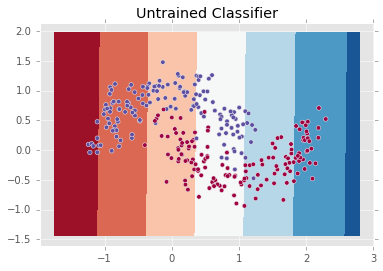

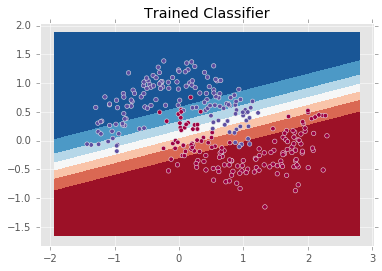

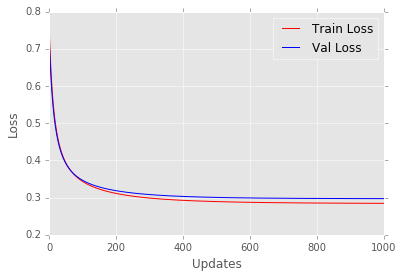

In [33]:
# defining a function to make predictions using our classifier
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {input_placeholder: X_in}
    # secondly our fetches
    fetches = [output]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

# Training loop
num_epochs = 1000

train_cost, val_cost, val_acc = [],[],[]

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    
    # initializing all variables 
    init = tf.global_variables_initializer()
    sess.run(init)
    utils.plot_decision_boundary(lambda x: pred(x, sess), X_val, Y_val)
    plt.title("Untrained Classifier")
    
    # We iterate over the amount of epochs specified (1 epoch = all train data)
    for e in range(num_epochs):
        ### TRAINING ###
        # what to feed to our train_op
        # notice we onehot encode our predictions to change shape from (batch,) -> (batch, num_output)
        feed_dict_train = {input_placeholder: X_train, 
                           y: utils.onehot(Y_train, num_outputs)}
        
        # deciding which parts to fetch, train_op makes the classifier "train"
        fetches_train = [train_op, cross_entropy]
        
        # running the train_op
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        # storing cross entropy (second fetch argument, so index=1)
        train_cost += [res[1]]
    
        ### VALIDATING ###
        # what to feed our accuracy op
        feed_dict_valid = {input_placeholder: X_val, y: utils.onehot(Y_val, num_outputs)}

        # deciding which parts to fetch
        fetches_valid = [cross_entropy, accuracy]

        # running the validation
        res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
        val_cost += [res[0]]
        val_acc += [res[1]]

        if e % 100 == 0:
            print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                  %(e, train_cost[-1],val_cost[-1],val_acc[-1]))
        
        if e % (num_epochs - 200) == 0: 
            clear_output()

    ### TESTING ###
    # what to feed our accuracy op
    feed_dict_test = {input_placeholder: X_test, y: utils.onehot(Y_test, num_outputs)}

    # deciding which parts to fetch
    fetches_test = [cross_entropy, accuracy]

    # running the validation
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    test_cost = res[0]
    test_acc = res[1]
    
    print("\nTest Cost: %0.3f\tTest Accuracy: %0.3f"%(test_cost, test_acc))
    
    # For plotting purposes
    utils.plot_decision_boundary(lambda x: pred(x, sess), X_test, Y_test)

# notice: we do not need to use the session environment anymore, so returning from it.
plt.title("Trained Classifier")

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

# Assignments

 1) A linear logistic classifier is only able to create a linear decision boundary. Change the Logistic classifier into a (non-linear) Neural network by inserting a dense hidden layer between the input and output layers of the model
 
 2) Experiment with multiple hidden layers or more / less hidden units. What happens to the decision boundary?
 
 3) Overfitting: When increasing the number of hidden layers / units the neural network will fit the training data better by creating a highly nonlinear decision boundary. If the model is to complex it will often generalize poorly to new data (validation and test set). Can you obseve this from the training and validation errors? 
 
 4) We used the vanilla stocastic gradient descent algorithm for parameter updates. This is usually slow to converge and more sophisticated pseudo-second-order methods usually works better. Try changing the optimizer to [adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) or [Momentum](https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer)